 # ***Machine Learning Classifiers on Real-World Data***

**Name:** Asimakis Kydros

**SRN:** 3881

**e-mail:** asimakis@csd.auth.gr

This short project aims to show why baseline classification models, such as the KNearestNeighbors and the NearestCentroid classifiers, pale when used in real-world problems, here simulated through the CIFAR-10 dataset.

In [2]:
# always run this cell
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.decomposition import PCA

SAMPLE = 10000
SEED = 42

CIFAR-10 is a toy dataset, yet its (relatively) monstrous proportions will highlight our problem nicely.

Before the sets can be used, they need to be flattened from 4D pixel image arrays to 2D.

In [3]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(50000, 3072)
X_test = X_test.reshape(10000, 3072)

X_sample = X_train[:SAMPLE]
y_sample = y_train[:SAMPLE]

As mentioned above, we will focus on the KNN and NCC classifiers. This is a helper function to handle the fitting and project the models' scores clearly on the screen.

In [4]:
def fit_score (xtrain, ytrain, xtest, ytest, sample):
    knn1 = KNeighborsClassifier (n_neighbors=1).fit(xtrain, ytrain.ravel())
    knn3 = KNeighborsClassifier (n_neighbors=3).fit(xtrain, ytrain.ravel())
    ncc = NearestCentroid ()
    ncc.fit(xtrain, ytrain.ravel())

    xsample, ysample = xtrain[:sample], ytrain[:sample]

    print(f'''1-Nearest Neighbor
        Train accuracy ({sample = }): {knn1.score(xsample, ysample) * 100:.2f}%
         Test accuracy: {knn1.score(xtest, ytest) * 100:.2f}%

3-Nearest Neighbors
        Train accuracy ({sample = }): {knn3.score(xsample, ysample) * 100:.2f}%
         Test accuracy: {knn3.score(xtest, ytest) * 100:.2f}%

Nearest Centroid
        Train accuracy ({sample = }): {ncc.score(xsample, ysample) * 100:.2f}%
         Test accuracy: {ncc.score(xtest, ytest) * 100:.2f}%'''
    )

* **Raw data training:**

    Firstly, let's not help the models at all and see how well they do on their own against sheer numbers.

    We are primarily focused on the testing data accuracy score, but also scoring with a sample of the training data will give further insight on how well the model handles itself, possible overfitting, etc.

In [4]:
fit_score(X_train, y_train, X_test, y_test, 10000)

1-Nearest Neighbor
        Train accuracy (sample = 10000): 100.00%
         Test accuracy: 35.39%

3-Nearest Neighbors
        Train accuracy (sample = 10000): 58.11%
         Test accuracy: 33.03%

Nearest Centroid
        Train accuracy (sample = 10000): 27.41%
         Test accuracy: 27.74%


    Expected results for above code cell (ETA ~9mins):
    
        1-Nearest Neighbor
                Train accuracy (sample = 10000): 100.00%
                 Test accuracy: 35.39%

        3-Nearest Neighbors
                Train accuracy (sample = 10000): 58.11%
                 Test accuracy: 33.03%

        Nearest Centroid
                Train accuracy (sample = 10000): 27.41%
                 Test accuracy: 27.74%

As we can see, all three models sit around 30%, which is realistically fairly good when keeping in mind the complexity of the problem, but practically unacceptable for scientific use.

The neighbor models seem to manage a bit better in training, though. 1NN scores 100%, which is neither surprising nor useful, as the sample points were used in training and thus have themselves as closest neighbors. 3NN is correct more often than not, but still unusable.

* **Grayscaling:**

    The CIFAR-10 dataset has colored images. We can try to help the models' performance by dropping the complexity through discarding the colors. This can be done in several ways; the easiest is to average all 3 channels. A prettier version is Linear approximation:

$$ Y' = 0.299\cdot R' + 0.587\cdot G' + 0.114\cdot B' $$

*(Thanks to https://e2eml.school/convert_rgb_to_grayscale#:~:text=Easy%20peasy%3A%20Average%20the%20channels,to%20get%20the%20grayscale%20value).*

In [5]:
# https://github.com/brohrer/lodgepole/blob/master/lodgepole/image_tools.py
def rgb2gray_approx(rgb_img):
    """
    Convert *linear* RGB values to *linear* grayscale values.
    """
    red = rgb_img[:, :, 0]
    green = rgb_img[:, :, 1]
    blue = rgb_img[:, :, 2]

    gray_img = (
        0.299 * red
        + 0.587 * green
        + 0.114 * blue)

    return gray_img

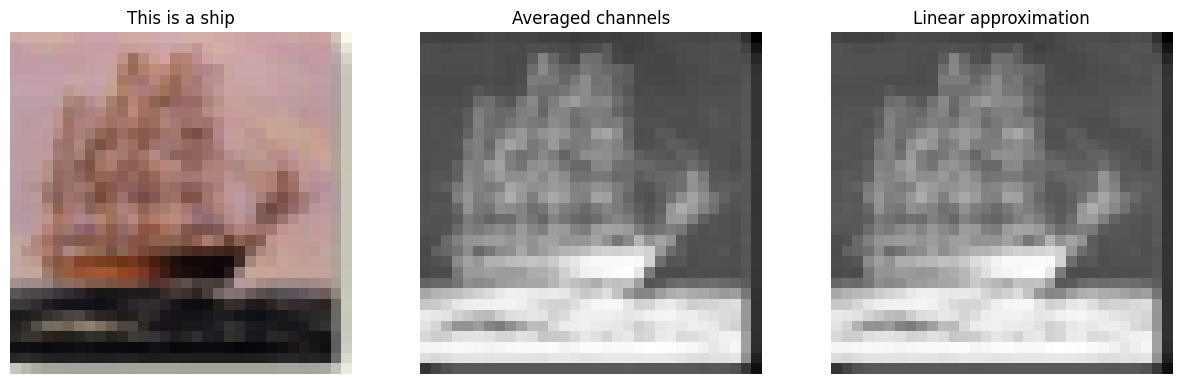

In [6]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
img = random.randint(0, 50000)

# get random image from train set
colored_image = X_train[img].reshape(32, 32, 3)
label = y_train[img][0]

fig = plt.figure(figsize=(15, 25))

# plot the colored version
fig.add_subplot(1, 3, 1)
plt.imshow(colored_image)
plt.axis('off')
plt.title(f'This is a{"n" if label < 2 else ""} {label_names[label]}')

# plot the mean grayscale version
fig.add_subplot(1, 3, 2)
plt.imshow(np.mean(colored_image, axis=2), cmap='gray_r')
plt.axis('off')
plt.title('Averaged channels')

# plot the LA grayscale version
fig.add_subplot(1, 3, 3)
plt.imshow(rgb2gray_approx(colored_image), cmap='gray_r')
plt.axis('off')
plt.title('Linear approximation')

plt.show()

In [7]:
# reshape to grayscale
X_train_grayscale = np.array([
    np.mean(img, axis=2) for img in X_train.reshape(50000, 32, 32, 3)
])

# reshape back to 2D array
X_train_grayscale = X_train_grayscale.reshape(50000, 1024)

# do the same for the test set
X_test_grayscale = np.array([
    np.mean(img, axis=2) for img in X_test.reshape(10000, 32, 32, 3)
])

X_test_grayscale = X_test_grayscale.reshape(10000, 1024)

# predict
print('Averaging channels:\n')
fit_score(X_train_grayscale, y_train, X_test_grayscale, y_test, 10000)

Averaging channels:

1-Nearest Neighbor
        Train accuracy (sample = 10000): 100.00%
         Test accuracy: 30.90%

3-Nearest Neighbors
        Train accuracy (sample = 10000): 53.53%
         Test accuracy: 28.77%

Nearest Centroid
        Train accuracy (sample = 10000): 25.02%
         Test accuracy: 24.72%


    Expected results for above code cell (ETA ~3mins):

        Averaging channels:

        1-Nearest Neighbor
                Train accuracy (sample = 10000): 100.00%
                 Test accuracy: 30.90%

        3-Nearest Neighbors
                Train accuracy (sample = 10000): 53.53%
                 Test accuracy: 28.77%

        Nearest Centroid
                Train accuracy (sample = 10000): 25.02%
                 Test accuracy: 24.72%

In [8]:
# reshape to grayscale
X_train_grayscale = np.array([
    rgb2gray_approx(img) for img in X_train.reshape(50000, 32, 32, 3)
])

# reshape back to 2D array
X_train_grayscale = X_train_grayscale.reshape(50000, 1024)

# do the same for the test set
X_test_grayscale = np.array([
    rgb2gray_approx(img) for img in X_test.reshape(10000, 32, 32, 3)
])

X_test_grayscale = X_test_grayscale.reshape(10000, 1024)

# predict
print('Linear approximation:\n')
fit_score(X_train_grayscale, y_train, X_test_grayscale, y_test, 10000)

Linear approximation:

1-Nearest Neighbor
        Train accuracy (sample = 10000): 100.00%
         Test accuracy: 30.18%

3-Nearest Neighbors
        Train accuracy (sample = 10000): 53.72%
         Test accuracy: 27.93%

Nearest Centroid
        Train accuracy (sample = 10000): 24.68%
         Test accuracy: 24.12%


    Expected results for above code cell (ETA ~4mins):

        Linear approximation:
        
        1-Nearest Neighbor
                Train accuracy (sample = 10000): 100.00%
                 Test accuracy: 30.18%

        3-Nearest Neighbors
                Train accuracy (sample = 10000): 53.72%
                 Test accuracy: 27.93%

        Nearest Centroid
                Train accuracy (sample = 10000): 24.68%
                 Test accuracy: 24.12%

We can see that our models now fare even worse; in our attempt to drop the complexity we discarded apparently vital information for learning.

* **PCA decomposition:**

    Another way to drop the complexity and attempt to achieve better results is to mold this huge problem into an equivalent smaller one, by reducing the data's dimensions through PCA decomposition.

    Of course, we can guess that blindly restricting the problem into a small number of dimensions (e.g. 2 for the extreme case) will completely gut the models' ability to predict anything. We need to test multiple dimensionalities and compare the results. One good way to achieve this is to use multiple invariances and check which percentage of the information we have to keep and how much we can throw away.

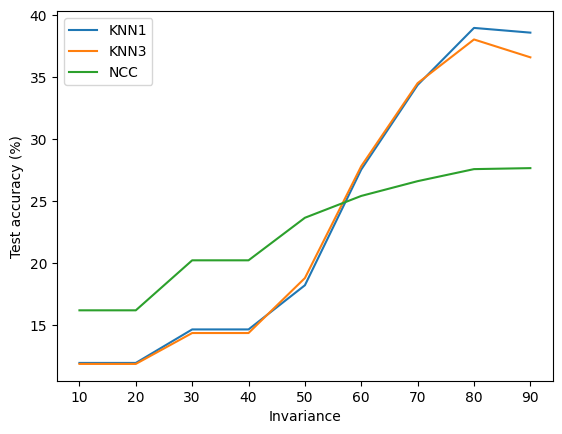

In [5]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
ncc = NearestCentroid()

results_knn1, results_knn3, results_ncc = [], [], []

for invariance in range(10, 100, 10):
    # reduced to current dimensional barrier
    pca = PCA(invariance / 100)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # train and test with reduced data
    knn1.fit(X_train_reduced, y_train.ravel())
    knn3.fit(X_train_reduced, y_train.ravel())
    ncc.fit(X_train_reduced, y_train.ravel())

    results_knn1.append(round(knn1.score(X_test_reduced, y_test) * 100, 2))
    results_knn3.append(round(knn3.score(X_test_reduced, y_test) * 100, 2))
    results_ncc.append(round(ncc.score(X_test_reduced, y_test) * 100, 2))

# plot results
x_axis = list(range(10, 100, 10))
plt.plot(x_axis, results_knn1, label='KNN1')
plt.plot(x_axis, results_knn3, label='KNN3')
plt.plot(x_axis, results_ncc, label='NCC')
plt.ylabel('Test accuracy (%)')
plt.xlabel('Invariance')
plt.legend()
plt.show()

    Expected output of above code cell (ETA ~30mins):

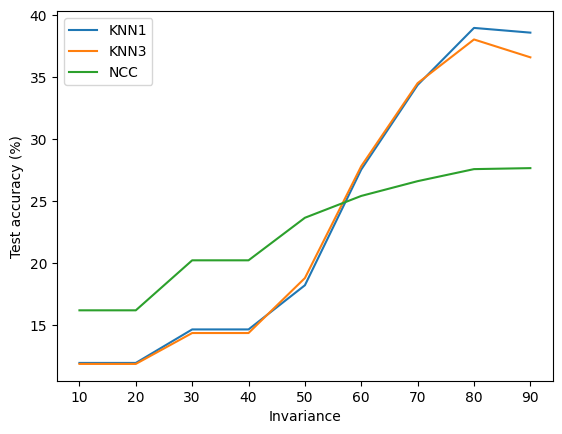

We can actually see that the models peak in testing performance at around 80% invariance, which means a good 20% of the information stored in these images is not relevant in learning.

Training now with the best percentage yields the following:

In [6]:
pca = PCA(0.8)

X_train_best = pca.fit_transform(X_train)
X_test_best = pca.transform(X_test)

fit_score(X_train_best, y_train, X_test_best, y_test, 10000)

1-Nearest Neighbor
        Train accuracy (sample = 10000): 100.00%
         Test accuracy: 38.96%

3-Nearest Neighbors
        Train accuracy (sample = 10000): 64.57%
         Test accuracy: 38.03%

Nearest Centroid
        Train accuracy (sample = 10000): 27.13%
         Test accuracy: 27.58%


    Expected output for above code cell (ETA ~3mins):

        1-Nearest Neighbor
                Train accuracy (sample = 10000): 100.00%
                 Test accuracy: 38.96%

        3-Nearest Neighbors
                Train accuracy (sample = 10000): 64.57%
                 Test accuracy: 38.03%

        Nearest Centroid
                Train accuracy (sample = 10000): 27.13%
                 Test accuracy: 27.58%

As was implied by the graph, the KNN models are being their best selves, with a testing accuracy for both at almost 40%. A big leap from the raw data version. While still not useful in practice, its a respectable improvement. NCC is still struggling to break 30%, and by the graph it can be seen that the model stagnates even with the rest of the information involved.

* **Conclusions**

    There are many other ways to drop complexity in order to improve performance, but the bottom line becomes clear; problems of such magnitude, as the image classification problem, cannot be adequately tackled with rudimentary machine learning algorithms.

    Some other approach is needed, one that can handle increased complexity, such as multilayer perceptrons or convolutional neural networks.